# Imminent ICU Admission Classifier with Logistic Regression

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pickle
import scipy

import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from scikitplot.metrics import *

from utils.data_utils import set_group_splits
from utils.metrics import BinaryAvgMetrics, get_best_model
from utils.plots import *

In [4]:
from args import args
vars(args)

{'path': PosixPath('../data'),
 'workdir': PosixPath('../data/workdir/lr'),
 'figdir': PosixPath('../data/workdir/lr/figures'),
 'structured_csv': PosixPath('../data/modelready_structured.csv'),
 'unstructured_csv': PosixPath('../data/modelready_unstructured.csv'),
 'mm_csv': PosixPath('../data/modelready_mm.csv'),
 'modeldir': PosixPath('../data/workdir/lr/models'),
 'vectordir': PosixPath('../data/workdir/vectordir'),
 'str_cols_pkl': PosixPath('../data/str_cols.pkl')}

In [5]:
str_cols = pickle.load(open(args.str_cols_pkl, 'rb'))
cols = ['hadm_id'] + str_cols + ['note', 'imi_adm_label']

In [9]:
mm_notes_vitals = pd.read_csv(args.mm_csv, usecols=cols)
mm_notes_vitals = mm_notes_vitals[mm_notes_vitals['imi_adm_label'] != -1].reset_index(drop=True)

notes_common = mm_notes_vitals[['hadm_id', 'note', 'imi_adm_label']].copy().reset_index(drop=True)
vitals_common = mm_notes_vitals[['hadm_id'] + str_cols + ['imi_adm_label']].copy().reset_index(drop=True)

print(vitals_common.shape, notes_common.shape, mm_notes_vitals.shape, vitals_common['hadm_id'].nunique(), notes_common['hadm_id'].nunique(), mm_notes_vitals['hadm_id'].nunique())

(33870, 51)

In [16]:
seed = 643
save = False

## Unstructured Data Classifier Dev

In [17]:
df = set_group_splits(notes_common.copy(), group_col='hadm_id', seed=seed)

train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

g = train_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in training set:{(g[1]/g.sum())*100:0.1f}%")
g = test_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in test set:{(g[1]/g.sum())*100:0.1f}%")

Prevalence of positive class in training set:23.0%
Prevalence of positive class in test set:19.9%


In [19]:
# vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=60_000)
# x_note_train = vectorizer.fit_transform(train_df['note'])
# x_note_test = vectorizer.transform(test_df['note'])

# with open(args.vectordir/f'bigram_643.pkl', 'wb') as f:
#   pickle.dump(vectorizer, f)
#   pickle.dump(x_note_train, f)
#   pickle.dump(x_note_test, f)

In [20]:
with open(args.vectordir/'bigram_643.pkl', 'rb') as f:
  vectorizer = pickle.load(f)
  x_note_train = pickle.load(f)
  x_note_test = pickle.load(f)
  
y_train, y_test = train_df['imi_adm_label'], test_df['imi_adm_label']
x_note_train.shape, x_note_test.shape, y_train.shape, y_test.shape

((27752, 60000), (6118, 60000), (27752,), (6118,))

In [21]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(x_note_train, y_train)

prob = clf.predict_proba(x_note_test)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test]

/net/vaosl01/opt/NFS/su0/anaconda3/envs/phd/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0, 0.5, 'Sensitivity')

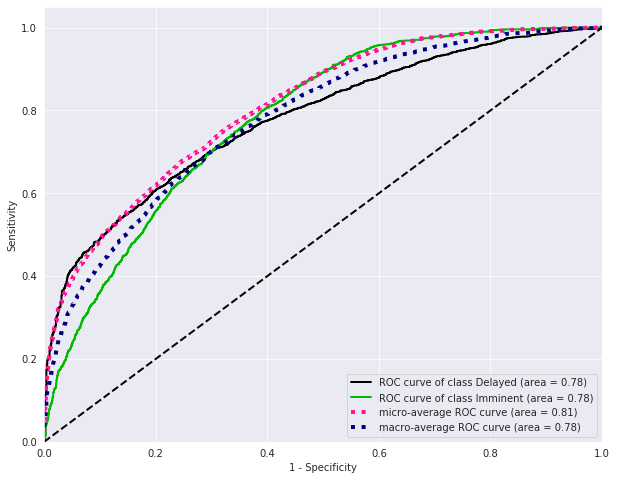

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

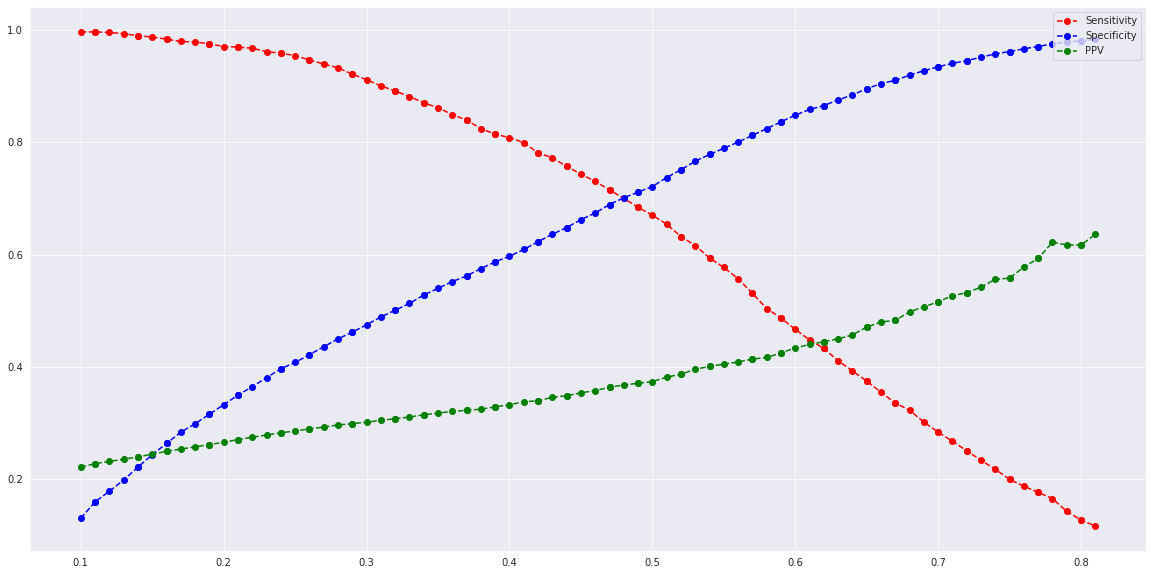

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100)

if save:
  fig.savefig(args.figdir/f'lr_notes_vital_metrics_vary.pdf', dpi=300, box_inches='tight', pad_inches=0)

Best Youden Threshold = 0.41


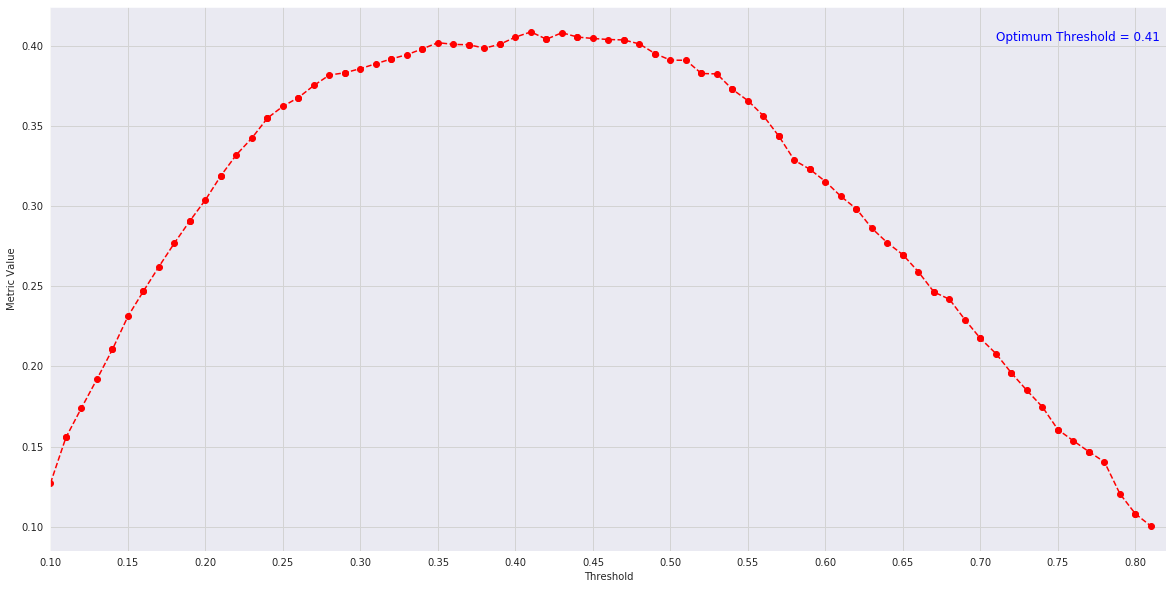

In [25]:
fig, ax = plt.subplots(figsize=(20, 10))
best_threshold = plot_thresh_metric(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100, show_f1=False)
ax.text(0.71, ax.get_ylim()[1]*0.95, f'Optimum Threshold = {best_threshold[0]}', fontsize=12, color='b')
print(f"Best Youden Threshold = {best_threshold[0]}")

if save:
  fig.savefig(args.figdir/f'lr_notes_vital_threshold_guide.pdf', dpi=300, box_inches='tight', pad_inches=0)

In [26]:
threshold = 0.41
pred = (pos_prob > threshold).astype(np.int64)
label_preds = [labels[i] for i in pred]
cm = confusion_matrix(y_test, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.799
specificity,0.609
ppv,0.338
npv,0.924
f1,0.475
auroc,0.780
threshold,0.410


In [ ]:
fig, ax = plt.subplots(figsize=(11, 8))
plot_confusion_matrix(label_test, label_preds, x_tick_rotation=45, ax=ax, normalize=False)

## Multimodal Classifier Dev

In [27]:
df = set_group_splits(mm_notes_vitals.copy(), group_col='hadm_id', seed=seed)

train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

g = train_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in training set:{(g[1]/g.sum())*100:0.1f}%")
g = test_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in test set:{(g[1]/g.sum())*100:0.1f}%")

Prevalence of positive class in training set:23.0%
Prevalence of positive class in test set:19.9%


In [ ]:
with open(args.vectordir/'bigram_643.pkl', 'rb') as f:
  vectorizer = pickle.load(f)
  x_note_train = pickle.load(f)
  x_note_test = pickle.load(f)
  
y_train, y_test = train_df['imi_adm_label'], test_df['imi_adm_label']
x_note_train.shape, x_note_test.shape, y_train.shape, y_test.shape

In [ ]:
str_cols = pickle.load(open(args.str_cols_pkl, 'rb'))

x_vitals_train, x_vitals_test = train_df[str_cols].values, test_df[str_cols].values
x_vitals_train.shape, x_vitals_test.shape

In [ ]:
x_train = scipy.sparse.hstack((x_vitals_train, x_note_train)).tocsr()
x_test = scipy.sparse.hstack((x_vitals_test, x_note_test)).tocsr()
x_train.shape, x_test.shape

In [ ]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(x_train, y_train)

prob = clf.predict_proba(x_test)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test]

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100)

if save:
  fig.savefig(args.figdir/f'lr_notes_vital_metrics_vary.pdf', dpi=300, box_inches='tight', pad_inches=0)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
best_threshold = plot_thresh_metric(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100, show_f1=False)
ax.text(0.71, ax.get_ylim()[1]*0.95, f'Optimum Threshold = {best_threshold[0]}', fontsize=12, color='b')
print(f"Best Youden Threshold = {best_threshold[0]}")

if save:
  fig.savefig(args.figdir/f'lr_notes_vital_threshold_guide.pdf', dpi=300, box_inches='tight', pad_inches=0)

In [ ]:
threshold = 0.37
pred = (pos_prob > threshold).astype(np.int64)
label_preds = [labels[i] for i in pred]
cm = confusion_matrix(y_test, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

In [ ]:
fig, ax = plt.subplots(figsize=(11, 8))
plot_confusion_matrix(label_test, label_preds, x_tick_rotation=45, ax=ax, normalize=False)

### Notes and Vitals

In [ ]:
df = set_group_splits(full_common_vital.copy(), group_col='hadm_id', seed=seed)

train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

g = train_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in training set:{(g[1]/g.sum())*100:0.1f}%")
g = test_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in test set:{(g[1]/g.sum())*100:0.1f}%")

In [ ]:
# vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=60_000)
# x_note_train = vectorizer.fit_transform(train_df['note'])
# x_note_test = vectorizer.transform(test_df['note'])

# with open(args.workdir/f'bi_gram_full_vital_643.pkl', 'wb') as f:
#   pickle.dump(vectorizer, f)
#   pickle.dump(x_note_train, f)
#   pickle.dump(x_note_test, f)

In [ ]:
with open(args.workdir/f'vectordir/bi_gram_vital_643.pkl', 'rb') as f:
  vectorizer = pickle.load(f)
  x_note_train = pickle.load(f)
  x_note_test = pickle.load(f)
  
y_train, y_test = train_df['imi_adm_label'], test_df['imi_adm_label']
x_note_train.shape, x_note_test.shape, y_train.shape, y_test.shape

In [ ]:
x_str_train, x_str_test = train_df[args.str_vital_cols].values, test_df[args.str_vital_cols].values
x_str_train.shape, x_str_test.shape

In [ ]:
x_train = scipy.sparse.hstack((x_str_train, x_note_train)).tocsr()
x_test = scipy.sparse.hstack((x_str_test, x_note_test)).tocsr()
x_train.shape, x_test.shape

In [ ]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(x_train, y_train)

prob = clf.predict_proba(x_test)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test]

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100)

if save:
  fig.savefig(args.figdir/f'{args.model}_full_vital_metrics_vary.pdf', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
best_threshold = plot_thresh_metric(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100)
ax.text(0.71, ax.get_ylim()[1] * 0.9, f'Optimum Threshold = {best_threshold[0]}', fontsize=12, color='b')
print(best_threshold)

if save:
  fig.savefig(args.figdir/f'{args.model}_full_vital_threshold_guide.pdf', dpi=300)

In [ ]:
threshold = 0.43
pred = (pos_prob > threshold).astype(np.int64)
label_preds = [labels[i] for i in pred]
cm = confusion_matrix(y_test, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

In [ ]:
fig, ax = plt.subplots(figsize=(11, 8))
plot_confusion_matrix(label_test, label_preds, x_tick_rotation=45, ax=ax, normalize=False)

In [ ]:
pos = 1220
control = 4898

## All Single Model Dev

In [ ]:
args.str_all_cols = pickle.load(open(args.path/'str_all_cols.pkl', 'rb'))
args.all_cols=['hadm_id'] + args.str_all_cols + ['note', 'imi_adm_label']

In [ ]:
full_common_all = pd.read_csv(args.all_csv, usecols=args.all_cols)
full_common_all = full_common_all[full_common_all['imi_adm_label'] != -1].reset_index(drop=True)
notes_common_all = full_common_all[['hadm_id', 'note', 'imi_adm_label']].copy().reset_index(drop=True)

print(notes_common_all.shape, full_common_all.shape)
notes_common_all['hadm_id'].nunique(), full_common_all['hadm_id'].nunique()

In [ ]:
# notes_common_all.dropna(inplace=True)
# notes_common_all.reset_index(drop=True, inplace=True)

# all_hadms = set(full_common_all['hadm_id'].unique()).intersection(notes_common_all['hadm_id'].unique())

# full_common_all = full_common_all[full_common_all['hadm_id'].isin(all_hadms)].reset_index(drop=True)
# notes_common_all = notes_common_all[notes_common_all['hadm_id'].isin(all_hadms)].reset_index(drop=True)

# print(notes_common_all.shape, full_common_all.shape)
# notes_common_all['hadm_id'].nunique(), full_common_all['hadm_id'].nunique()

In [ ]:
# full_common_all.dropna(inplace=True)
# full_common_all.reset_index(drop=True, inplace=True)

In [ ]:
# full_common_all[['note']] = full_common_all.groupby('hadm_id')[['note']].ffill()

# full_common_all.dropna(inplace=True)
# full_common_all.reset_index(drop=True, inplace=True)

# x = pd.DataFrame(full_common_all.isna().sum(), columns=['sum']).reset_index()
# x['sum'].sum()

### Notes only

In [ ]:
df = set_group_splits(notes_common_all.copy(), group_col='hadm_id', seed=seed)

train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

g = train_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in training set:{(g[1]/g.sum())*100:0.1f}%")
g = test_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in test set:{(g[1]/g.sum())*100:0.1f}%")

In [ ]:
# vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=60_000)
# x_note_train = vectorizer.fit_transform(train_df['note'])
# x_note_test = vectorizer.transform(test_df['note'])

# with open(args.workdir/f'vectordir/bi_gram_all_643.pkl', 'wb') as f:
#   pickle.dump(vectorizer, f)
#   pickle.dump(x_note_train, f)
#   pickle.dump(x_note_test, f)

In [ ]:
with open(args.workdir/f'vectordir/bi_gram_all_643.pkl', 'rb') as f:
  vectorizer = pickle.load(f)
  x_note_train = pickle.load(f)
  x_note_test = pickle.load(f)
  
y_train, y_test = train_df['imi_adm_label'], test_df['imi_adm_label']
x_note_train.shape, x_note_test.shape, y_train.shape, y_test.shape

In [ ]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(x_note_train, y_train)

prob = clf.predict_proba(x_note_test)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test]

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

In [ ]:
save = True

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100)

if save:
  fig.savefig(args.figdir/f'{args.model}_notes_all_metrics_vary.pdf', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
best_threshold = plot_thresh_metric(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100)
ax.text(0.71, ax.get_ylim()[1] * 0.9, f'Optimum Threshold = {best_threshold[0]}', fontsize=12, color='b')
print(best_threshold)

if save:
  fig.savefig(args.figdir/f'{args.model}_notes_all_threshold_guide.pdf', dpi=300)

In [ ]:
threshold = 0.46
pred = (pos_prob > threshold).astype(np.int64)
label_preds = [labels[i] for i in pred]
cm = confusion_matrix(y_test, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

In [ ]:
fig, ax = plt.subplots(figsize=(11, 8))
plot_confusion_matrix(label_test, label_preds, x_tick_rotation=45, ax=ax, normalize=True)

### Notes and All structured

In [ ]:
df = set_group_splits(full_common_all.copy(), group_col='hadm_id', seed=seed)

train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

g = train_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in training set:{(g[1]/g.sum())*100:0.1f}%")
g = test_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in test set:{(g[1]/g.sum())*100:0.1f}%")

In [ ]:
# vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=60_000)
# x_note_train = vectorizer.fit_transform(train_df['note'])
# x_note_test = vectorizer.transform(test_df['note'])

# with open(args.workdir/f'vectordir/bi_gram_full_vital_643.pkl', 'wb') as f:
#   pickle.dump(vectorizer, f)
#   pickle.dump(x_note_train, f)
#   pickle.dump(x_note_test, f)

In [ ]:
with open(args.workdir/f'vectordir/bi_gram_all_643.pkl', 'rb') as f:
  vectorizer = pickle.load(f)
  x_note_train = pickle.load(f)
  x_note_test = pickle.load(f)
  
y_train, y_test = train_df['imi_adm_label'], test_df['imi_adm_label']
x_note_train.shape, x_note_test.shape, y_train.shape, y_test.shape

In [ ]:
x_str_train, x_str_test = train_df[args.str_all_cols].values, test_df[args.str_all_cols].values
x_str_train.shape, x_str_test.shape

In [ ]:
x_train = scipy.sparse.hstack((x_str_train, x_note_train)).tocsr()
x_test = scipy.sparse.hstack((x_str_test, x_note_test)).tocsr()
x_train.shape, x_test.shape

In [ ]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(x_train, y_train)

prob = clf.predict_proba(x_test)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test]

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100)

if save:
  fig.savefig(args.figdir/f'{args.model}_full_all_metrics_vary.pdf', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
best_threshold = plot_thresh_metric(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100)
ax.text(0.71, ax.get_ylim()[1] * 0.9, f'Optimum Threshold = {best_threshold[0]}', fontsize=12, color='b')
print(best_threshold)

if save:
  fig.savefig(args.figdir/f'{args.model}_full_all_threshold_guide.pdf', dpi=300)

In [ ]:
threshold = 0.5
pred = (pos_prob > threshold).astype(np.int64)
label_preds = [labels[i] for i in pred]
cm = confusion_matrix(y_test, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

In [ ]:
fig, ax = plt.subplots(figsize=(11, 8))
plot_confusion_matrix(label_test, label_preds, x_tick_rotation=45, ax=ax, normalize=False)

In [ ]:
pos = 1220
control = 4898

## Metrics

In [ ]:
with open(args.workdir/f'preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  probs = pickle.load(f)
  preds = pickle.load(f)

bam = BinaryAvgMetrics(targs, preds, [prob[:, 1] for prob in probs])
bam.get_avg_metrics(defn=True)

In [ ]:
bam.get_avg_metrics(conf=0.95)

In [ ]:
fig, ax = plt.subplots(figsize=(11, 8))
plot_cm(ax, bam.cm_avg, ['Delayed', 'Imminent'])

if save:
  fig.savefig(args.figdir/f'mean_cm.pdf', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, probs)

if save:
  fig.savefig(args.figdir/f'mean_roc.pdf', dpi=300)